# Create perturbed FY files with ad-hoc covariance matrix (all energies)

This notebook follows the procedure to generate ad-hoc covariance matrices for independent fission yields from chain yield evaluations, as described in:
- [Fiorito et al., Generation of fission yield covariances to correct discrepancies in the nuclear data libraries, Annals of Nuclear Energy, Vol. 88, 2016](https://doi.org/10.1016/j.anucene.2015.10.027)
- [Fission yield covariance generation and uncertainty propagation through fission pulse decay heat calculation, Annals of Nuclear Energy, Vol. 69, 2014](https://doi.org/10.1016/j.anucene.2014.01.038)

In [1]:
import sandy
import pandas as pd
from os.path import join
import numpy as np
import random, sys
import matplotlib.pyplot as plt
import seaborn as sns

## Extract FYs and covariance data for U235 fission

In [2]:
za = 92235
tape = sandy.get_endf6_file("jeff_33", "nfpy", za * 10)
fy = sandy.Fy.from_endf6(tape)

In [3]:
energies = fy.data.E.unique()

## Generate perturbation coefficients for all energies and write them to file

Use normalization to chain yields as a constraint to create a covariance matrix. 

In [4]:
tape_rdd = sandy.get_endf6_file("jeff_33", "decay", "all")
rdd = sandy.DecayData.from_endf6(tape_rdd)  # this can take a while

In [5]:
sensitivity = rdd.get_chain_yield_sensitivity()
chfy = sandy.fy.get_chain_yields()
set([(row.ZAM, row.E) for i, row in chfy.iterrows()])

{(902270, 'thermal'),
 (902290, 'thermal'),
 (902320, 'fast'),
 (902320, 'high energy'),
 (912310, 'fast'),
 (922320, 'thermal'),
 (922330, 'fast'),
 (922330, 'high energy'),
 (922330, 'thermal'),
 (922340, 'fast'),
 (922340, 'high energy'),
 (922350, 'fast'),
 (922350, 'high energy'),
 (922350, 'thermal'),
 (922360, 'fast'),
 (922360, 'high energy'),
 (922370, 'fast'),
 (922380, 'fast'),
 (922380, 'high energy'),
 (922380, 'spontaneous fission'),
 (932370, 'fast'),
 (932370, 'high energy'),
 (932370, 'thermal'),
 (932380, 'fast'),
 (942380, 'fast'),
 (942390, 'fast'),
 (942390, 'high energy'),
 (942390, 'thermal'),
 (942400, 'fast'),
 (942400, 'high energy'),
 (942400, 'thermal'),
 (942410, 'fast'),
 (942410, 'thermal'),
 (942420, 'fast'),
 (942420, 'high energy'),
 (942420, 'thermal'),
 (952410, 'fast'),
 (952410, 'high energy'),
 (952410, 'thermal'),
 (952421, 'thermal'),
 (952430, 'fast'),
 (962420, 'fast'),
 (962430, 'fast'),
 (962430, 'thermal'),
 (962440, 'fast'),
 (962440, 'spo

Choose among the above fissioning systems for which chain yields are available from [England & Rider, 1993](https://www-nds.iaea.org/endf349/la-ur-94-3106.pdf).

In [6]:
def gls_update(fy, zam, energy, s, y_extra, Vy_extra):
    mask = f"ZAM=={zam} & E=={energy} & MT==454"
    fy_data = fy.data.query(mask)
    fy_post = fy.data.copy()
    
    s_ = np.array(s.reindex(index=y_extra.index, columns=fy_data.ZAP).fillna(0))
    
    # Put data in a appropiate format
    x_prior_ = np.array(fy_data.FY)
    Vx_prior_ = np.diag(fy_data.DFY**2)
    y_extra_ = np.array(y_extra)
    Vy_extra_ = np.array(Vy_extra.data)
    
    G = s_ @ Vx_prior_ @ s_.T + Vy_extra_
    G_inv = np.linalg.pinv(G)
    
    # GlS update values
    x_post = x_prior_ + Vx_prior_ @ s_.T @ G_inv @ (y_extra_ - s_ @ x_prior_)
    
    # GlS update covariance
    Vx_post = Vx_prior_ - Vx_prior_ @ s_.T @ G_inv @ s_ @ Vx_prior_
    
    Vx_post = sandy.CategoryCov(Vx_post, index=fy_data.ZAP, columns=fy_data.ZAP)
    fy_post.loc[fy_data.index, "FY"] = x_post
    fy_post.loc[fy_data.index, "DFY"] = Vx_post.get_std().values
    return fy.__class__(fy_post), Vx_post

sampling IFY for energy 2.530e-02 eV...


sampling IFY for energy 4.000e+05 eV...
sampling IFY for energy 1.400e+07 eV...


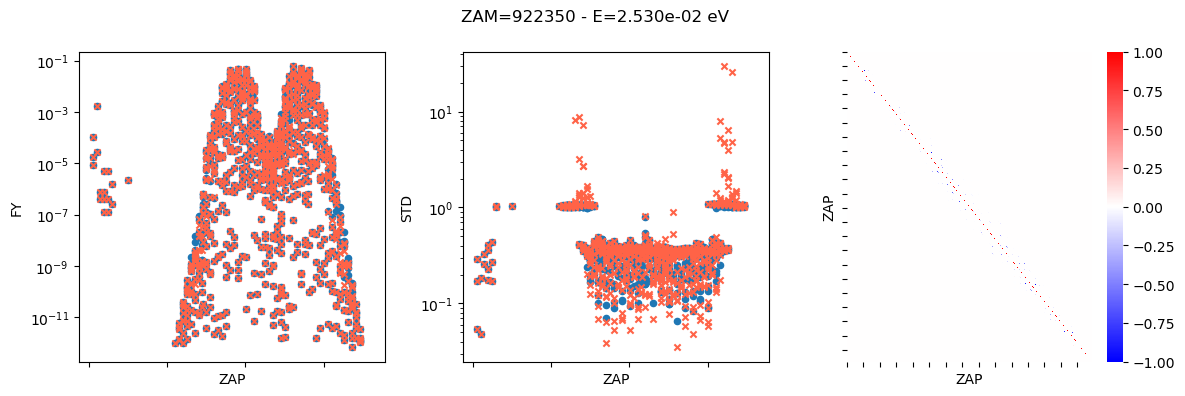

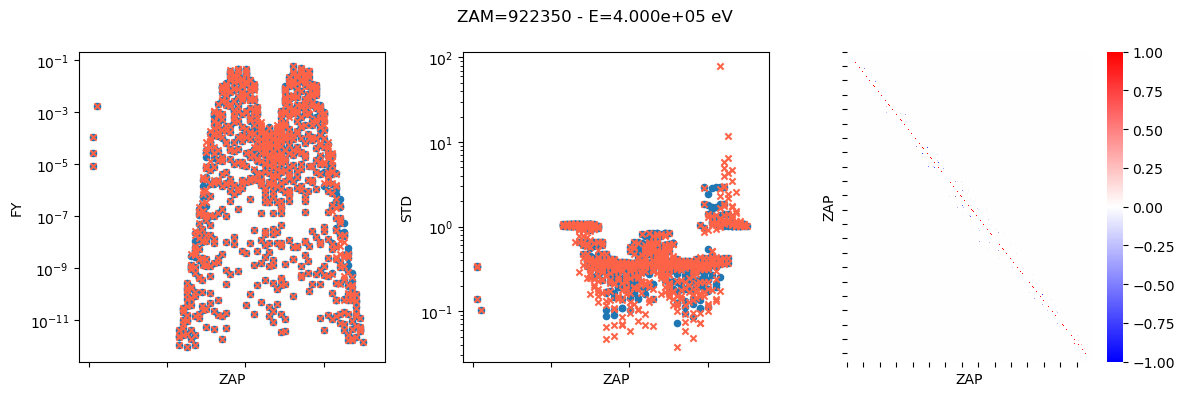

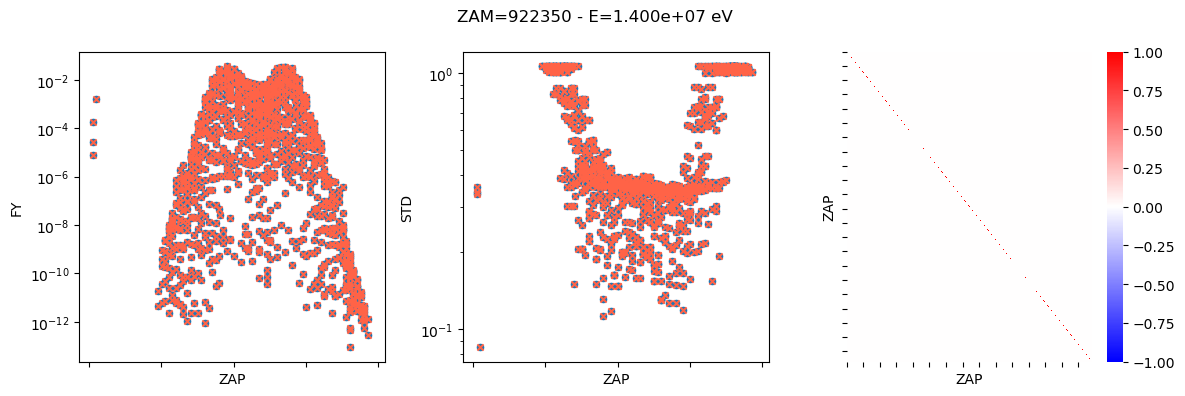

In [8]:
nsmp = 1000  # sample size
smp = {}
acovs = {}
rcovs = {}
acovs_post = {}
rcovs_post = {}
for e, etext in zip(energies, ["thermal", "fast", "high_energy"]):  # change this for the nuclide you choose

    # Run GLS update algorithm to create covariance matrix
    mask = f"E=={e} & MT==454"
    ify = fy.data.query(mask).set_index("ZAP")
    absolute_cov = sandy.CategoryCov.from_stdev(ify.DFY)
    relative_cov = sandy.CategoryCov.from_stdev((ify.DFY / ify.FY).fillna(0))

    acovs[e] = absolute_cov
    rcovs[e] = relative_cov

    
    extra = chfy.query(f"E=='{etext}' & ZAM=={za*10}").set_index("A")
    y_extra = extra.CHY
    Vy_extra = sandy.CategoryCov.from_stdev(extra.DCHY)

    fy_post, cov_post = gls_update(fy, za*10, e, sensitivity, y_extra, Vy_extra)

    ify_post = fy_post.data.query(mask).set_index("ZAP")
    absolute_cov_post = cov_post
    relative_cov_post = cov_post.data / (ify_post.FY.values.reshape(-1, 1) @ ify_post.FY.values.reshape(1, -1))
    # Symmetrize the resulting matrix
    relative_cov_post = sandy.CategoryCov((relative_cov_post + relative_cov_post.T).fillna(0) / 2)

    acovs_post[e] = absolute_cov_post
    rcovs_post[e] = relative_cov_post


    # Plot the generated covariance data and compare to original data 
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    ax = axs[0]
    ify.reset_index().plot(x="ZAP", y="FY", ax=ax, kind="scatter")
    ify_post.reset_index().plot(x="ZAP", y="FY",ax=ax, kind="scatter", color="tomato", marker="x")
    ax.tick_params(labelbottom=False)
    ax.set(yscale="log")
    
    ax = axs[1]
    relative_cov.get_std().reset_index().plot(x="ZAP", y="STD", kind="scatter", ax=ax)
    relative_cov_post.get_std().reset_index().plot(x="ZAP", y="STD", kind="scatter", color="tomato", marker="x", ax=ax)
    ax.tick_params(labelbottom=False)
    ax.set(yscale="log")

    ax = axs[2]
    sns.heatmap(relative_cov_post.get_corr().data, vmin=-1, vmax=1., cmap="bwr", ax=ax)
    ax.tick_params(labelbottom=False, labelleft=False)
    
    fig.suptitle(f"ZAM={za*10} - E={e:.3e} eV")
    fig.tight_layout()


    # Draw random sample from the new covariance data
    seed = random.randrange(2**32 - 1)    # create a seed, need to change it for the different energies
    print(f"sampling IFY for energy {e:.3e} eV...")
    smp[e] = relative_cov_post.sampling(nsmp, seed=seed)   # sample from posterior covariance matrix

In [9]:
with pd.ExcelWriter(f'PERT_{za}_MF8_MT454_COV.xlsx') as writer:
    for e, s in smp.items():
        s.data.to_excel(writer, sheet_name=f'{e:.3e}')

## Read coefficients from perturbation file and generate random FY ENDF-6 files

Skip the part above if you already have the file of perturbations.

In [10]:
smp = pd.read_excel(f'PERT_{za}_MF8_MT454_COV.xlsx', sheet_name=None, index_col=0)
smp = {float(k): v for k, v in smp.items()}

Compare convergence of relative perturbation coefficients in EXCEL file.

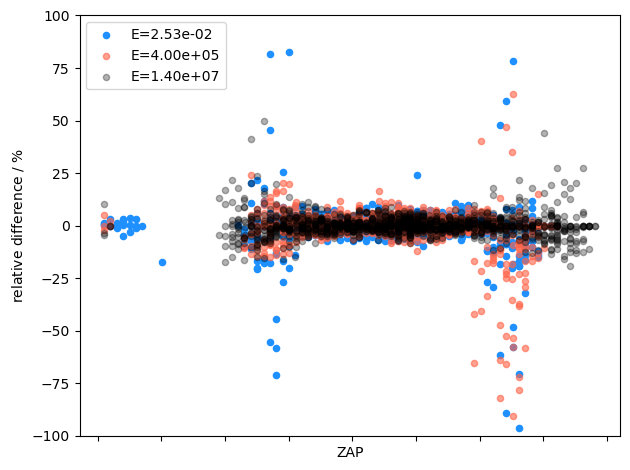

In [11]:
fig, ax = plt.subplots()
(smp[energies[0]].std(axis=1) / rcovs_post[energies[0]].get_std() - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="dodgerblue", label=f"E={energies[0]:.2e}")
(smp[energies[1]].std(axis=1) / rcovs_post[energies[1]].get_std() - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="tomato", alpha=.6, label=f"E={energies[1]:.2e}")
(smp[energies[2]].std(axis=1) / rcovs_post[energies[2]].get_std() - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="k", alpha=.3, label=f"E={energies[2]:.2e}")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="ZAP")
ax.tick_params(labelbottom=False)
fig.tight_layout()

In [12]:
za = 92235
tape = sandy.get_endf6_file("jeff_33", "nfpy", za * 10)
nfpy = sandy.Fy.from_endf6(tape)

In [13]:
smp_min = 0   # write ENDF-6 file only in the sample range [smp_min, smp_max]
smp_max = 99
file_template = "u235_fy_cov_{}.jeff33"
for ismp in range(smp_min, smp_max+1):
    file = file_template.format(ismp)
    f = sandy.Fy(nfpy.data.copy())
    for e, s in smp.items():
        idx_ify = nfpy.data.query(f"E=={float(e)} & MT==454").index
        idx_cfy = nfpy.data.query(f"E=={float(e)} & MT==459").index
        f.data.loc[idx_ify, "DFY"] = f.data.loc[idx_ify, "FY"]            # just for me, i copy the original IFYs where uncertainties should be, so i can compare them to the perturbed ones (anyways I don't use uncertainties)
        f.data.loc[idx_cfy, "DFY"] = f.data.loc[idx_cfy, "FY"]            # same but for CFYs
        f.data.loc[idx_ify, "FY"] *= s[ismp].values                # IMPORTANT, this does not update the CFYs, which in random ENDF-6 file are inconsistent with the perturbed IFYs
        #f = f.apply_qmatrix(922350, e, rdd, keep_fy_index=True)      # Run this if you want to update the CFYs (slower), or else comment it out
    print(f"writing file '{file}'...")
    f.to_endf6(tape).to_file(file)

writing file 'u235_fy_cov_0.jeff33'...
writing file 'u235_fy_cov_1.jeff33'...
writing file 'u235_fy_cov_2.jeff33'...
writing file 'u235_fy_cov_3.jeff33'...
writing file 'u235_fy_cov_4.jeff33'...
writing file 'u235_fy_cov_5.jeff33'...
writing file 'u235_fy_cov_6.jeff33'...
writing file 'u235_fy_cov_7.jeff33'...
writing file 'u235_fy_cov_8.jeff33'...
writing file 'u235_fy_cov_9.jeff33'...
writing file 'u235_fy_cov_10.jeff33'...
writing file 'u235_fy_cov_11.jeff33'...
writing file 'u235_fy_cov_12.jeff33'...
writing file 'u235_fy_cov_13.jeff33'...
writing file 'u235_fy_cov_14.jeff33'...
writing file 'u235_fy_cov_15.jeff33'...
writing file 'u235_fy_cov_16.jeff33'...
writing file 'u235_fy_cov_17.jeff33'...
writing file 'u235_fy_cov_18.jeff33'...
writing file 'u235_fy_cov_19.jeff33'...
writing file 'u235_fy_cov_20.jeff33'...
writing file 'u235_fy_cov_21.jeff33'...
writing file 'u235_fy_cov_22.jeff33'...
writing file 'u235_fy_cov_23.jeff33'...
writing file 'u235_fy_cov_24.jeff33'...
writing fi

Compare convergence of fission yields in ENDF-6 files.

In [14]:
sfy = {ismp: sandy.Fy.from_endf6(sandy.Endf6.from_file(f"u235_fy_cov_{ismp}.jeff33")) for ismp in range(smp_min, smp_max+1)}

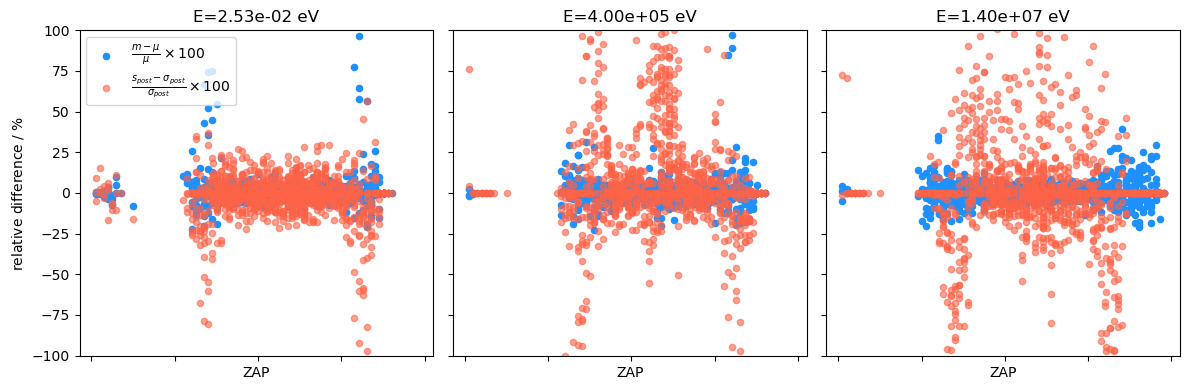

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax = axs[0]
e = energies[0]
mask = f"E=={e} and MT==454"
d = pd.DataFrame({k: v.data.query(mask).set_index("ZAP").FY for k, v in sfy.items()})
(d.mean(axis=1) / nfpy.data.query(mask).set_index("ZAP").FY - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="dodgerblue", label="$\\frac{m- \\mu}{\\mu} \\times 100$")
((d.std(axis=1) / d.mean(axis=1)).fillna(0) / rcovs_post[energies[0]].get_std() - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="tomato", alpha=.6, label="$\\frac{s_{post}- \\sigma_{post}}{\\sigma_{post}} \\times 100$")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="ZAP", title=f"E={e:.2e} eV")
ax.tick_params(labelbottom=False)

ax = axs[1]
e = energies[1]
mask = f"E=={e} and MT==454"
d = pd.DataFrame({k: v.data.query(mask).set_index("ZAP").FY for k, v in sfy.items()})
(d.mean(axis=1) / nfpy.data.query(mask).set_index("ZAP").FY - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="dodgerblue", label="$\\frac{m- \\mu}{\\mu} \\times 100$")
((d.std(axis=1) / d.mean(axis=1)).fillna(0) / rcovs_post[energies[0]].get_std() - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="tomato", alpha=.6, label="$\\frac{s_{post}- \\sigma_{post}}{\\sigma_{post}} \\times 100$")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="ZAP", title=f"E={e:.2e} eV")
ax.tick_params(labelbottom=False)
ax.get_legend().remove()

ax = axs[2]
e = energies[2]
mask = f"E=={e} and MT==454"
d = pd.DataFrame({k: v.data.query(mask).set_index("ZAP").FY for k, v in sfy.items()})
(d.mean(axis=1) / nfpy.data.query(mask).set_index("ZAP").FY - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="dodgerblue", label="$\\frac{m- \\mu}{\\mu} \\times 100$")
((d.std(axis=1) / d.mean(axis=1)).fillna(0) / rcovs_post[energies[0]].get_std() - 1).fillna(0).multiply(100).rename("DIFF").reset_index().plot(x="ZAP", y="DIFF", kind="scatter", ax=ax, color="tomato", alpha=.6, label="$\\frac{s_{post}- \\sigma_{post}}{\\sigma_{post}} \\times 100$")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="ZAP", title=f"E={e:.2e} eV")
ax.tick_params(labelbottom=False)
ax.get_legend().remove()

fig.tight_layout()